In [2]:
%cd ..

/home/pablo/long-transformers


In [3]:
# add the project root to the python path
import sys
sys.path.append('.')

In [4]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import csv

## Text retrieval

In [8]:
def transform(input_file: str, output_dir: str):
    csv.field_size_limit(sys.maxsize)
    os.makedirs(output_dir, exist_ok=True)
    
    with open(input_file, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        for idx, row in enumerate(reader):
            label, _, _, text1, text2 = row
            label = int(float(label))
            text1 = text1[2:-1]
            text2 = text2[2:-1]
            
            item = {"label": label, "text1": text1, "text2": text2}
            
            with open(f"{output_dir}/{idx}.json", "w") as f:
                json.dump(item, f)


In [9]:
for subset in ["train", "eval", "test"]:
    print(f"Transforming {subset}...")
    transform(
        f"datasets/lra_release/tsv_data/new_aan_pairs.{subset}.tsv",
        f"datasets/text_retrieval/{subset}"
    )

Transforming train...
Transforming eval...
Transforming test...


## Listops

In [13]:
def compress(split="train"):
    dataset_path = f"datasets/lra_release/listops-1000/basic_{split}.tsv"
    new_dataset_path = f"datasets/lra_release/listops-1000/basic_{split}_compressed.tsv"

    df = pd.read_csv(dataset_path, sep="\t")
    df["Source"] = df["Source"].str.replace(r'[()]', '', regex=True)
    df["Source"] = df["Source"].str.replace(r'\s+', ' ', regex=True)
    df["Source"] = df["Source"].str.strip()

    df.to_csv(new_dataset_path, sep="\t", index=False)

In [15]:
for split in ["train", "val", "test"]:
    compress(split)

In [4]:
df = pd.read_csv("datasets/lra_release/listops-1000/basic_train_compressed.tsv", sep="\t")

In [12]:
df["Source"] = df["Source"].str.replace(r'[()]', '', regex=True)
df["Source"] = df["Source"].str.replace(r'\s+', ' ', regex=True)
df["Source"] = df["Source"].str.strip()
df

,Source,Target
0,[MIN 1 [MED 8 0 1 3 0 6 1 ] 7 [MED [SM 4 [MED ...,1
1,[MAX 1 8 3 0 0 9 5 8 [MIN 9 6 [MAX 2 [SM [SM 1...,9
2,[SM 2 [MED 6 [SM [MAX 2 9 ] 4 2 5 [MED 2 8 ] ]...,4
3,[MED 9 1 2 1 8 [SM 3 [SM 1 6 [MED [MED [MIN 6 ...,3
4,[MIN [MIN 3 [SM 0 [MED [MED [MED [MAX 6 [SM 0 ...,0
...,...,...
95995,[SM [MED 5 [SM 9 7 [MAX [MED 2 0 ] 1 5 [MED 0 ...,6
95996,[MIN 5 9 0 [MIN [MAX [MAX 0 0 ] [MAX [MIN 3 2 ...,0
95997,[MED 8 [MAX 7 [MAX 0 6 [MAX 7 [MIN 1 7 4 [SM 9...,6
95998,[MED 6 [MED 9 [MIN 1 6 1 [MIN [MAX 6 2 9 5 0 5...,4


In [6]:
df["first_token"] = df["Source"].str.split(" ").str[0]

### Simple predictor 1: based on first token only

In [7]:
df

,Source,Target,first_token
0,[MIN 1 [MED 8 0 1 3 0 6 1 ] 7 [MED [SM 4 [MED ...,1,[MIN
1,[MAX 1 8 3 0 0 9 5 8 [MIN 9 6 [MAX 2 [SM [SM 1...,9,[MAX
2,[SM 2 [MED 6 [SM [MAX 2 9 ] 4 2 5 [MED 2 8 ] ]...,4,[SM
3,[MED 9 1 2 1 8 [SM 3 [SM 1 6 [MED [MED [MIN 6 ...,3,[MED
4,[MIN [MIN 3 [SM 0 [MED [MED [MED [MAX 6 [SM 0 ...,0,[MIN
...,...,...,...
95995,[SM [MED 5 [SM 9 7 [MAX [MED 2 0 ] 1 5 [MED 0 ...,6,[SM
95996,[MIN 5 9 0 [MIN [MAX [MAX 0 0 ] [MAX [MIN 3 2 ...,0,[MIN
95997,[MED 8 [MAX 7 [MAX 0 6 [MAX 7 [MIN 1 7 4 [SM 9...,6,[MED
95998,[MED 6 [MED 9 [MIN 1 6 1 [MIN [MAX 6 2 9 5 0 5...,4,[MED


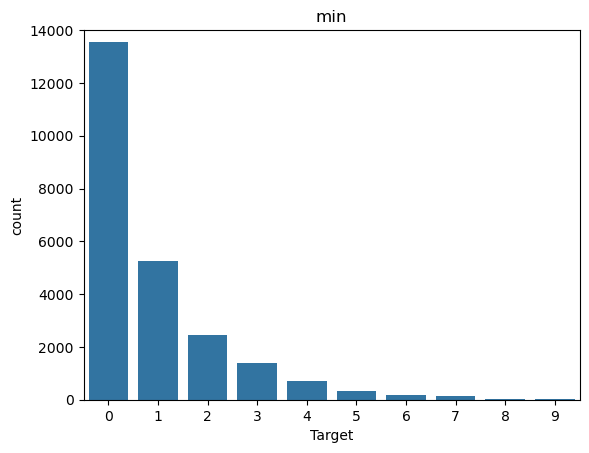

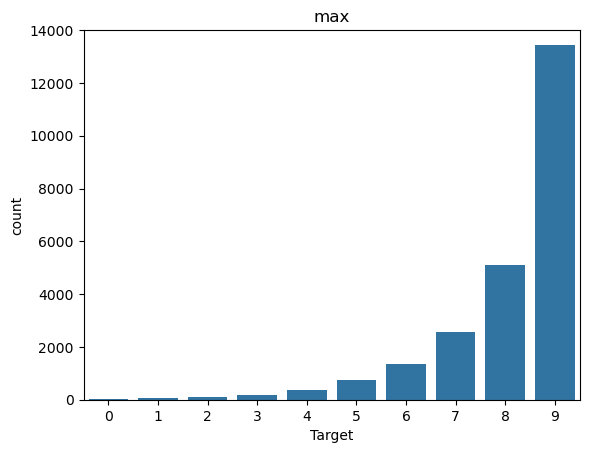

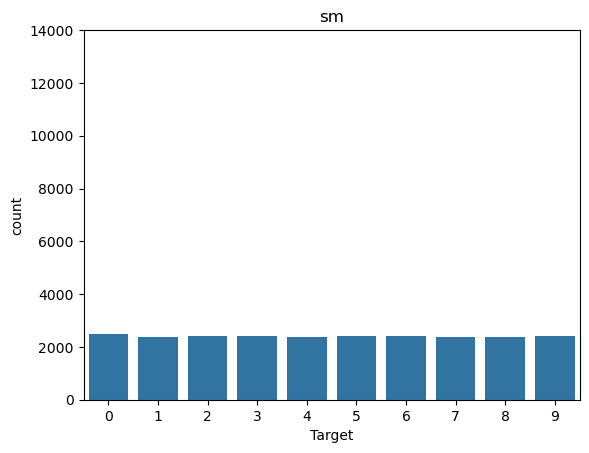

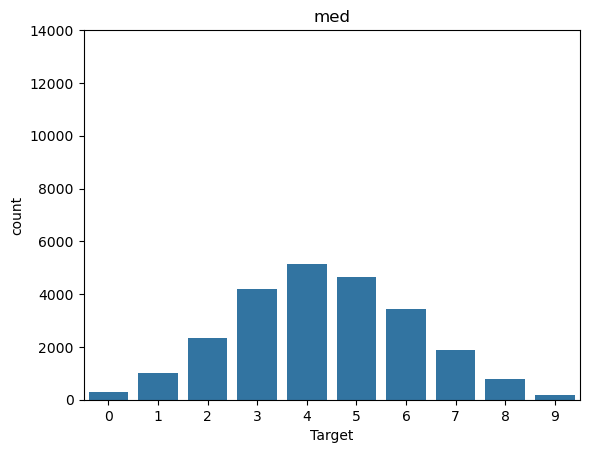

In [11]:
# for each first token, plot the bar plot of Target
for token in df["first_token"].unique():
    token_clean = token[1:].lower()
    sns.countplot(x="Target", data=df[df["first_token"] == token])
    plt.title(token_clean)
    plt.ylim(0, 14000)
    # save png
    plt.savefig(f"listops_hist_{token_clean}.png")
    plt.show()


In [56]:
predict = {"[MED": 4, "[MAX": 9, "[MIN": 0, "[SM": 4, }
cnt = 0
successes = 0

for first_token, target in df[["first_token", "Target"]].values:
    prediction = predict.get(first_token, -1)
    if prediction == target:
        successes += 1
    cnt += 1

print(successes / cnt)

0.35961458333333335


### Simple predictor 2: truncating at a given depth and solving

In [57]:
predict = {"[MED": 4, "[MAX": 9, "[MIN": 0, "[SM": 4, }
operators = {
    "[MED": lambda x: sorted(x)[len(x) // 2],
    "[MAX": max,
    "[MIN": min,
    "[SM": lambda l : sum(l) % 10,
}

def truncate_tree(source, depth=1):
    current_depth = -1
    truncated_tokens = []
    for token in source.split():
        if token.startswith("["):
            current_depth += 1

        if current_depth < depth:
            truncated_tokens.append(token)
        elif current_depth == depth and token.startswith("["):
            truncated_tokens.append(str(predict[token]))

        if token.startswith("]"):
            current_depth -= 1
            
    
    return " ".join(truncated_tokens)

def solve_tree(tree: list[str]):
    ops: list[callable] = []
    operands: list[list[int]] = [[]]

    for token in tree:
        if token.startswith("["):
            ops.append(operators[token])
            operands.append([])
        elif token.startswith("]"):
            result = ops[-1](operands[-1])
            ops.pop()
            operands.pop()

            operands[-1].append(result)
        else:
            operands[-1].append(int(token))
    
    return operands[0][0]

In [58]:
DEPTH = 2

cnt = 0
successes = 0

for source, target in df[["Source", "Target"]].values:
    truncated_source = truncate_tree(source, depth=DEPTH)
    prediction = solve_tree(truncated_source.split())
    if prediction == target:
        successes += 1
    cnt += 1

print(successes / cnt)

0.6530625


### Simple predictor 3: based on first token and token count

In [59]:
df_counts = df.join(df["Source"].str.split(" ").apply(lambda x: pd.Series(x).value_counts()))
df_counts.iloc[:, 2:]

,first_token,],5,3,8,7,2,9,0,1,6,4,[MAX,[MIN,[MED,[SM
0,[MIN,97,58,58,57,54,51,48,44,42,36,34,28,26,24,19
1,[MAX,265,135,140,127,134,150,139,148,132,150,138,72,54,69,70
2,[SM,92,51,57,50,41,45,49,42,39,40,51,21,25,26,20
3,[MED,227,127,109,110,110,121,114,109,109,118,113,52,65,58,52
4,[MIN,72,33,39,37,37,32,32,37,37,40,39,19,17,18,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,[SM,138,70,56,88,61,74,72,69,84,57,70,37,36,36,29
95996,[MIN,222,103,111,132,109,115,126,111,104,89,113,59,54,53,56
95997,[MED,141,73,52,56,93,64,71,68,61,60,76,41,33,37,30
95998,[MED,131,50,69,58,58,72,60,78,57,73,66,29,32,40,30


In [60]:
pd.get_dummies(df_counts, columns=["first_token"])

,Source,Target,],5,3,8,7,2,9,0,...,6,4,[MAX,[MIN,[MED,[SM,first_token_[MAX,first_token_[MED,first_token_[MIN,first_token_[SM
0,[MIN 1 [MED 8 0 1 3 0 6 1 ] 7 [MED [SM 4 [MED ...,1,97,58,58,57,54,51,48,44,...,36,34,28,26,24,19,False,False,True,False
1,[MAX 1 8 3 0 0 9 5 8 [MIN 9 6 [MAX 2 [SM [SM 1...,9,265,135,140,127,134,150,139,148,...,150,138,72,54,69,70,True,False,False,False
2,[SM 2 [MED 6 [SM [MAX 2 9 ] 4 2 5 [MED 2 8 ] ]...,4,92,51,57,50,41,45,49,42,...,40,51,21,25,26,20,False,False,False,True
3,[MED 9 1 2 1 8 [SM 3 [SM 1 6 [MED [MED [MIN 6 ...,3,227,127,109,110,110,121,114,109,...,118,113,52,65,58,52,False,True,False,False
4,[MIN [MIN 3 [SM 0 [MED [MED [MED [MAX 6 [SM 0 ...,0,72,33,39,37,37,32,32,37,...,40,39,19,17,18,18,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,[SM [MED 5 [SM 9 7 [MAX [MED 2 0 ] 1 5 [MED 0 ...,6,138,70,56,88,61,74,72,69,...,57,70,37,36,36,29,False,False,False,True
95996,[MIN 5 9 0 [MIN [MAX [MAX 0 0 ] [MAX [MIN 3 2 ...,0,222,103,111,132,109,115,126,111,...,89,113,59,54,53,56,False,False,True,False
95997,[MED 8 [MAX 7 [MAX 0 6 [MAX 7 [MIN 1 7 4 [SM 9...,6,141,73,52,56,93,64,71,68,...,60,76,41,33,37,30,False,True,False,False
95998,[MED 6 [MED 9 [MIN 1 6 1 [MIN [MAX 6 2 9 5 0 5...,4,131,50,69,58,58,72,60,78,...,73,66,29,32,40,30,False,True,False,False


In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into features (X) and target (y)
X = df_counts.iloc[:, 2:]  # Assuming the last 10 columns are the features
# one hot encode the first token
X = pd.get_dummies(X, columns=["first_token"])
y = df_counts["Target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.3525520833333333


### Data augmentation

In [82]:
import random
import math

operators = {
    "[MED": lambda x: sorted(x)[len(x) // 2],
    "[MAX": max,
    "[MIN": min,
    "[SM": lambda l : sum(l) % 10,
}

def augment(tree: list[str], logit_mean=0., logit_std=1.):
    ops: list[callable] = []
    operands: list[list[int]] = [[]]
    substrs: list[list[str]] = [[]]
    current_depth = 1

    for token in tree:
        if token.startswith("["):
            ops.append(token)
            operands.append([])
            substrs.append([])
            current_depth += 1

        elif token.startswith("]"):
            result = operators[ops[-1]](operands[-1])
            
            full_str = f"{ops[-1]} {' '.join(substrs[-1])} ]"
            result_str = str(result)

            ops.pop()
            operands.pop()
            substrs.pop()

            logit_contract = (current_depth - logit_mean) / logit_std
            prob_contract = 1. / (1. + math.exp(-logit_contract))
            if random.uniform(0, 1) < prob_contract:
                substrs[-1].append(result_str)
            else:
                substrs[-1].append(full_str)

            operands[-1].append(result)

            current_depth -= 1
        else:
            operands[-1].append(int(token))
            substrs[-1].append(token)
    
    return operands[0][0], substrs[0][0]

In [92]:
def augment(tree: list[str], logit_mean=0., logit_std=1.):
    ops: list[callable] = []
    operands: list[list[int]] = [[]]
    subtokens: list[list[str]] = [[]]
    current_depth = 1

    for token in tree:
        if token.startswith("["):
            ops.append(token)
            operands.append([])
            subtokens.append([])
            current_depth += 1

        elif token.startswith("]"):
            result = operators[ops[-1]](operands[-1])
            
            full_tokens: list[str] = [ops[-1]] + subtokens[-1] + ["]"]
            result_token: list[str] = [str(result)]

            ops.pop()
            operands.pop()
            subtokens.pop()

            logit_contract = (current_depth - logit_mean) / logit_std
            prob_contract = 1. / (1. + math.exp(-logit_contract))
            if random.uniform(0, 1) < prob_contract:
                subtokens[-1].extend(result_token)
            else:
                subtokens[-1].extend(full_tokens)

            operands[-1].append(result)

            current_depth -= 1
        else:
            operands[-1].append(int(token))
            subtokens[-1].append(token)
    
    return subtokens[0]

In [93]:
cnt = 0
for source, target in df[["Source", "Target"]].values:
    tokens = source.split()
    augmented_tokens = augment(tokens, 80., 10.)
    print(len(augmented_tokens))
    print(" ".join(augmented_tokens))

    cnt += 1
    if cnt >= 100: break

676
[MIN 1 [MED 8 0 1 3 0 6 1 ] 7 [MED [SM 4 [MED [SM 2 9 [MED 9 9 2 [MIN 8 3 5 4 8 5 6 2 6 0 ] 5 8 ] 2 6 8 9 8 ] 3 4 [SM 3 [SM [MIN [MIN [MED 5 8 7 9 1 7 1 ] 8 8 [MAX 2 5 ] 7 1 1 0 ] [MAX 6 2 5 0 [MIN 2 2 4 8 7 1 ] ] [MIN 1 [SM 3 6 4 0 5 ] 5 [MED 6 3 8 ] 0 ] 5 6 4 ] 3 7 8 0 6 ] 8 8 3 ] [MAX 5 1 3 5 ] [MED 3 [SM 3 2 6 [MAX 2 [MIN 8 [MAX 8 2 5 8 7 1 5 9 ] 0 0 9 [MAX 8 1 ] [MAX 5 9 4 1 1 3 2 3 2 ] 2 [MIN 1 9 0 2 9 3 8 ] ] [MAX [SM 5 1 7 9 3 8 2 2 2 4 ] [MAX 7 3 7 3 7 8 9 ] 8 [MIN 4 5 ] 4 0 2 7 4 ] [SM 2 5 [MIN 5 0 0 3 3 8 4 7 ] ] [MAX 8 8 5 3 8 0 ] 7 [MIN 3 8 6 1 5 7 0 5 9 ] [MAX 3 [MIN 4 7 6 ] 3 [SM 1 9 8 2 4 ] [MAX 1 5 7 3 ] 2 [MED 9 8 ] ] 3 4 ] ] 4 6 [MED 2 9 8 [MED [MAX 8 9 [MIN 2 1 0 5 2 1 0 0 1 ] 7 ] 7 [MED 1 8 3 ] [SM 6 9 9 ] [MIN [MED 7 3 3 1 0 ] 6 7 7 2 8 ] 3 8 ] 8 7 7 ] 3 4 1 ] ] 5 2 3 [MAX [MED 5 9 5 5 0 9 2 [MIN 0 2 [MAX [MIN 5 9 9 8 9 5 2 0 4 3 ] 0 [MED 2 3 0 [MED 0 4 8 7 8 9 6 6 7 1 ] 7 8 6 [MAX 2 7 7 1 9 9 2 ] 1 ] 5 [MAX 7 8 1 [SM 7 3 8 ] 3 8 2 ] 6 2 9 9 6 ] 5 0 [MED 8 7 4

## Text classification

In [5]:
from src.data_loaders.text_classification import TextClassificationDataset

/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_p

In [6]:
ds = TextClassificationDataset("datasets/aclImdb", "train")

In [7]:
sizes = []
cnt = 0
for idx in range(len(ds)):
    l = len(ds[idx]["text"])
    sizes.append(l)
    if l > 3000:
        cnt += 1


In [9]:
import seaborn as sns

<Axes: ylabel='Density'>

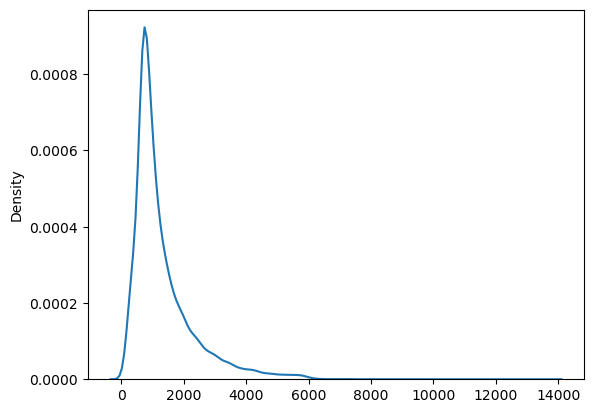

In [10]:
sns.kdeplot(sizes)

In [11]:
cnt

1813

In [14]:
len(ds)

25000

## Image

In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import random

from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torchvision.transforms import functional as tvF

/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_p

In [4]:
aug_pairs = [
    (("Invert", 0.1, None), ("Contrast", 0.2, 6)),
    (("Rotate", 0.7, 2), ("TranslateX", 0.3, 9)),
    (("Sharpness", 0.8, 1), ("Sharpness", 0.9, 3)),
    (("ShearY", 0.5, 8), ("TranslateY", 0.7, 9)),
    (("AutoContrast", 0.5, None), ("Equalize", 0.9, None)),
    (("ShearY", 0.2, 7), ("Posterize", 0.3, 7)),
    (("Color", 0.4, 3), ("Brightness", 0.6, 7)),
    (("Sharpness", 0.3, 9), ("Brightness", 0.7, 9)),
    (("Equalize", 0.6, None), ("Equalize", 0.5, None)),
    (("Contrast", 0.6, 7), ("Sharpness", 0.6, 5)),
    (("Color", 0.7, 7), ("TranslateX", 0.5, 8)),
    (("Equalize", 0.3, None), ("AutoContrast", 0.4, None)),
    (("TranslateY", 0.4, 3), ("Sharpness", 0.2, 6)),
    (("Brightness", 0.9, 6), ("Color", 0.2, 8)),
    (("Solarize", 0.5, 2), ("Invert", 0.0, None)),
    (("Equalize", 0.2, None), ("AutoContrast", 0.6, None)),
    (("Equalize", 0.2, None), ("Equalize", 0.6, None)),
    (("Color", 0.9, 9), ("Equalize", 0.6, None)),
    (("AutoContrast", 0.8, None), ("Solarize", 0.2, 8)),
    (("Brightness", 0.1, 3), ("Color", 0.7, 0)),
    (("Solarize", 0.4, 5), ("AutoContrast", 0.9, None)),
    (("TranslateY", 0.9, 9), ("TranslateY", 0.7, 9)),
    (("AutoContrast", 0.9, None), ("Solarize", 0.8, 3)),
    (("Equalize", 0.8, None), ("Invert", 0.1, None)),
    (("TranslateY", 0.7, 9), ("AutoContrast", 0.9, None)),
]
aug_probs = {
    aug: 0.0 for aug_pair in aug_pairs for aug, _, _ in aug_pair
}

for aug_pair in aug_pairs:
    for aug, prob, _ in aug_pair:
        aug_probs[aug] += prob * 1. / len(aug_pairs)

In [5]:
list(aug_probs.items())

[('Invert', 0.008),
 ('Contrast', 0.032),
 ('Rotate', 0.027999999999999997),
 ('TranslateX', 0.032),
 ('Sharpness', 0.11200000000000002),
 ('ShearY', 0.028),
 ('TranslateY', 0.136),
 ('AutoContrast', 0.2),
 ('Equalize', 0.188),
 ('Posterize', 0.012),
 ('Color', 0.11599999999999999),
 ('Brightness', 0.092),
 ('Solarize', 0.076)]

In [6]:
def apply_op(img, op_name: str, magnitude: float):
    if op_name == "Brightness":
        img = tvF.adjust_brightness(img, magnitude)
    elif op_name == "Color":
        img = tvF.adjust_saturation(img, magnitude)
    elif op_name == "Contrast":
        img = tvF.adjust_contrast(img, magnitude)
    elif op_name == "Sharpness":
        img = tvF.adjust_sharpness(img, magnitude)
    elif op_name == "Posterize":
        img = tvF.posterize(img, int(magnitude))
    elif op_name == "Solarize":
        img = tvF.solarize(img, magnitude)
    elif op_name == "AutoContrast":
        img = tvF.autocontrast(img)
    elif op_name == "Equalize":
        img = tvF.equalize(img)
    elif op_name == "Invert":
        img = tvF.invert(img)
    elif op_name == "Identity":
        pass
    else:
        raise ValueError(f"The provided operator {op_name} is not recognized.")
    return img

In [7]:
class RandomCifar10Augmentator(nn.Module):
    __AUGMENTATIONS = [
        ('Invert', 0.008),
        ('Contrast', 0.032),
        ('Sharpness', 0.11200000000000002),
        ('AutoContrast', 0.2),
        ('Equalize', 0.188),
        ('Posterize', 0.012),
        ('Color', 0.11599999999999999),
        ('Brightness', 0.092),
        ('Solarize', 0.076),
    ]

    __AUGMENTATION_SPACE = {
        'Brightness': (1.0, 1.9),
        'Color': (1.0, 1.9),
        'Contrast': (1.0, 1.9),
        'Sharpness': (1.0, 1.9),
        'Posterize': (0, 7),
        'Solarize': (0, 256),
    }

    def forward(self, img):
        for op_name, prob in self.__AUGMENTATIONS:
            if random.random() < prob:
                if op_name in self.__AUGMENTATION_SPACE:
                    magnitude = random.uniform(*self.__AUGMENTATION_SPACE[op_name])
                else:
                    magnitude = None
                img = apply_op(img, op_name, magnitude)
        return img

In [173]:
train_ds = torchvision.datasets.CIFAR10(
    "datasets/cifar10",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10, fill=0),
        RandomCifar10Augmentator(),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(1.0, 1.0), shear=10, fill=0, interpolation=InterpolationMode.BILINEAR),
        transforms.Grayscale(num_output_channels=3),
    ])
)

Files already downloaded and verified


(-0.5, 31.5, 31.5, -0.5)

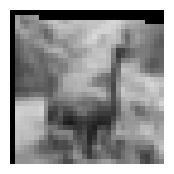

In [199]:
# plot the first image, make bigger
fig, ax = plt.subplots(figsize=(2, 2))
image = train_ds[6][0]
ax.imshow(image)
ax.axis('off')

In [106]:
# image to tensor
for idx in range(len(train_ds)):
    image = train_ds[idx][0]
    label = train_ds[idx][1]
    print((image.mean(dim=0) * 255).long())
    print(label)
    break

AttributeError: mean

## Pathfinder

In [1]:
%cd ..

/home/pablo/long-transformers


In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms

/home/pablo/.micromamba/envs/long-transformers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
DATA_PATH = "datasets/lra_release/pathfinder32/curv_contour_length_14"

In [7]:
class PathfinderSubdataset(Dataset):
    def __init__(self, data_path, dir_id):
        self.img_dir = os.path.join(data_path, "imgs", str(dir_id))

        # load the metadata
        metadata = pd.read_csv(os.path.join(data_path, "metadata", f"{dir_id}.npy"), sep=" ", header=None)
        self.labels = metadata.iloc[:, 3].values
        self.num_imgs = len(self.labels)

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, f"sample_{idx}.png"))
        label = self.labels[idx]
        return img, label

In [8]:
def build_dataset(data_path):
    num_dirs = len(glob.glob(os.path.join(DATA_PATH, "metadata", "*.npy")))
    return ConcatDataset([PathfinderSubdataset(data_path, dir_id) for dir_id in range(num_dirs)])

In [9]:
ds = build_dataset(DATA_PATH)

In [40]:
tr = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 0.9)),
    # transforms.ToTensor(),
])

tr_tensor = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=5, translate=(0.2, 0.2), scale=(0.6, 0.7), shear=20),
    transforms.ToTensor(),
])

(-0.5, 31.5, 31.5, -0.5)

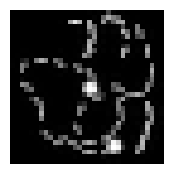

In [59]:
fig, ax = plt.subplots(figsize=(2, 2))
image = tr(ds[0][0])

# ax imshow as greyscale
ax.imshow(image, cmap="gray")
ax.axis('off')

In [24]:
tr_tensor(ds[0][0]).shape

torch.Size([1, 32, 32])

In [ ]:
# create dataloader from torchvision transforms

from torchvision import transforms

class PathfinderDataLoader:
    def __init__(self, data_path, batch_size, num_workers, shuffle=True):
        self.ds = build_dataset(data_path)
        self.dl = DataLoader(
            self.ds,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
        )

    def __iter__(self):
        return iter(self.dl)

    def __len__(self):
        return len(self.dl)

    def __getitem__(self, idx):
        return self.dl[idx]